In [140]:
#!/usr/bin/env python
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

def sorting(index):
    return [int(resname[4:]) for resname in index]

def normalize_df_column(df, col="Frac"):
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

In [212]:
def raw_df_hbonds(data, R1, R2):
    """data is the hbonds analysis output file from cpptraj 
    R1 an R2 are the regions selected to include in the hbond analysis. 
    This function will return df_hb_data, which is a dataframe that 
    includes the interactions as donor and acceptor of every residue 
    in the regions R1 and R2.
    """
    hb = pd.read_csv(data, delimiter=r"\s+")
#    hb = hb[hb.Frac > 0.05] #can be commented to plot also weakest interactions
    R1_as_acc = hb.rename(columns = {"#Acceptor": R1, "Donor": R2})
    R2_as_acc = hb.rename(columns = {"Donor": R1, "#Acceptor": R2})
    df_hb_data = pd.concat([R1_as_acc, R2_as_acc])
    df_hb_data.reset_index(drop=True, inplace=True)
    return df_hb_data

def residue_column_formating(df, col):
    res_num = lambda row: row[col][:3] + ' ' + row[col][4:].split('@',1)[0]
    num = lambda row: int(row[col][4:].split('@',1)[0])
    df[col.upper()] = df.apply(res_num, axis=1)
    df[f"{col} resid"] = df.apply(num, axis=1)
    return df.drop(col, axis=1)

def df_agregation(df, reg1, reg2, col='Frac'):
    df = df.groupby([reg1, reg2])[col].sum().reset_index()
    df = normalize_df_column(df)
    df = df.pivot_table(columns = reg1, index = reg2, values=col)
    df = df.fillna(0)
    df = df.sort_index(axis=0, key=sorting)
    df = df.sort_index(axis=1, key=sorting)
    return df

In [228]:
def hbonds_matrix(data, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1='substrate', R2='protein', col='Frac'):
    
    """data is the cpptraj output file
    R1 and R2 are the names regions selected to include in the hbond analysis.
    They are arbitrary names, doesn't carry any kind of information about the system.
    res_i_r1 and res_f_ri are the first and last residue in the region 1, the one 
    that will be ploted in the x axys.
    if selfinteracting == 'yes', the residues in the x axis will appear in the y axis
    also in order to show how much they are interacting between them.
    this function returns the hbonds matrix normalized to be ploted"""
    
    df = raw_df_hbonds(data, R1, R2)
    df = residue_column_formating(df, R1)
    df = residue_column_formating(df, R2)
    resid_mask = resid_mask
    reg1_res = [res for res in range(res_i_r1, res_f_r1 + 1)]
    
    if selfinteracting == 'yes':
        reg2_res = resid_mask
        reg1_res = [res for res in range(res_i_r1, res_f_r1 + 1)]
        matrix = df[df[f'{R1} resid'].isin(reg1_res)]
        return df_agregation(matrix, R1.upper(), R2.upper())
    else:
        reg2_res = [res for res in resid_mask if res not in reg1_res]
        matrix = df[df[f'{R1} resid'].isin(reg1_res)]
        matrix = matrix[matrix[f'{R2} resid'].isin(reg2_res)]
        return df_agregation(matrix, R1.upper(), R2.upper())

In [234]:
def single_plot(cpptraj_out, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1='substrate', R2='protein'):
                             
    """it will create the blue-white heat map with the hbond interactions"""
    df = hbonds_matrix(cpptraj_out, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1, R2)
    plt.title('H-Bonds Interactions', fontsize=15)
    sns.heatmap(df, cmap='Blues',linewidths=0.1, linecolor='gray', xticklabels=True, yticklabels=True)
    
def compare_plot(cpptraj_out1, cpptraj_out2, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1='substrate', R2='protein'):
    df1 = hbonds_matrix(cpptraj_out1, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1, R2)
    df2 = hbonds_matrix(cpptraj_out2, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1, R2)
    dif = (df1 - df2).fillna(0)
    
    plt.subplot(1,3,1)
    plt.title('Interactions traj1', fontsize=15)
    sns.heatmap(df1, cmap='Blues',linewidths=0.1, linecolor='gray', xticklabels=True, yticklabels=True) 
    
    plt.subplot(1,3,2)
    plt.title('Interactions traj2', fontsize=15)
    sns.heatmap(df2, cmap='Blues',linewidths=0.1, linecolor='gray', xticklabels=True, yticklabels=True) 

    plt.subplot(1,3,3)
    plt.title('Interactions traj1 - traj2', fontsize=15)
    cmap = sns.diverging_palette(20,250, as_cmap=True)
    dif = dif.sort_index(axis=0, key=sorting)
    dif = dif.sort_index(axis=1, key=sorting)
    sns.heatmap(dif,cmap=cmap,linewidths=0.1, center =0.0,linecolor='gray', xticklabels=True, yticklabels=True)

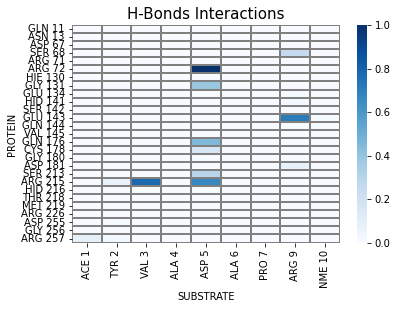

In [237]:
data = 'avg.out'
R1 = 'substrate' #input('Enter a string for the region/molecule to plot in the X axys > ')#
res_i_r1 = 1 #int(input(f'What is the resid of the FIRST residue in {region_one} > '))#
res_f_r1 = 10 #int(input(f'What is the resid of the LAST residue in {region_one} > '))#
R2 = 'protein'
resid_mask = range(1,279)#range(int(input("first residue in RESIDMASK in hbonds_cpptraj.sh")), int(input("last residue in RESIDMASK in hbonds_cpptraj.sh")) + 1)
selfinteracting = 'no'#input(f'the interactions of {region_one} with himself has to be also ploted? yes/no > ')
compare = 'no'#input('Do you want to compare this hbond analysis with another trajectory? yes/no > ')

if compare == 'yes':
    cpptraj_out2 = 'avg.out'#input('Enter the path for the cpptraj.out file for the SECOND trajectory to compare > ')#"all_avg_traj1.out"
    plt.figure(figsize=(15,8))
    compare_plot(cpptraj_out1,cpptraj_out2, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1, R2)
    plt.tight_layout()
else:
    single_plot(data, res_i_r1, res_f_r1, resid_mask, selfinteracting, R1, R2)

plt.show()